<a href="https://colab.research.google.com/github/erenatikk/CattleFaceRecognition/blob/main/CattleFacialRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
image_count = len(list(Path(cattleface_path).rglob('*.jpg')))

print(f'Dizin içindeki toplam görsel sayısı: {image_count}')

Dizin içindeki toplam görsel sayısı: 1246


In [ ]:
import os
import pandas as pd
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.optimizers import Adam
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.preprocessing import image
from pathlib import Path

In [ ]:
csv_path = '/content/drive/MyDrive/CattleFace/_annotations.csv'
df = pd.read_csv(csv_path)

In [ ]:
cattleface_path = '/content/drive/MyDrive/CattleFace/train'

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

In [ ]:
_annotations_path = '/content/drive/MyDrive/CattleFace/_annotations.csv'
df = pd.read_csv(_annotations_path)


train_generator = train_datagen.flow_from_dataframe(
    dataframe=df,
    directory=cattleface_path,
    x_col="filename",
    y_col="class",
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical"
)

Found 1246 validated image filenames belonging to 54 classes.


In [ ]:
# CSV dosyasını oku
csv_path = '/content/drive/MyDrive/CattleFace/valid_annotations.csv'
df = pd.read_csv(csv_path)

# Validation veri setini yükleyin
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=df,
    directory='/content/drive/MyDrive/CattleFace/valid',  # Görüntülerin bulunduğu dizin
    x_col='filename',
    y_col='class',  # Eğer sınıf etiketleri varsa, uygun sütunu seçin
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',  # Sınıflandırma için 'binary' ya da 'categorical' kullanın
    shuffle=False  # Verilerin karıştırılmasını istemiyoruz
)


Found 95 validated image filenames belonging to 54 classes.


In [ ]:
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
num_classes = df['class'].nunique()
print(num_classes)

54


In [ ]:
from keras.layers import GlobalAveragePooling2D

model = Sequential()
model.add(resnet_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
history = model.fit(
    train_generator,
    # steps_per_epoch=train_generator.samples // 32,
    epochs=6,
    validation_data=validation_generator,
    verbose = 2
    # validation_steps=validation_generator.samples // 32
)
print(history.history)

Epoch 1/6
39/39 - 930s - loss: 1.3014 - accuracy: 0.7047 - val_loss: 37.8926 - val_accuracy: 0.0105 - 930s/epoch - 24s/step
Epoch 2/6
39/39 - 855s - loss: 0.1792 - accuracy: 0.9526 - val_loss: 339.8568 - val_accuracy: 0.0526 - 855s/epoch - 22s/step
Epoch 3/6
39/39 - 855s - loss: 0.1261 - accuracy: 0.9591 - val_loss: 10.3974 - val_accuracy: 0.0526 - 855s/epoch - 22s/step
Epoch 4/6
39/39 - 852s - loss: 0.0630 - accuracy: 0.9799 - val_loss: 8.7273 - val_accuracy: 0.0211 - 852s/epoch - 22s/step
Epoch 5/6
39/39 - 850s - loss: 0.0622 - accuracy: 0.9815 - val_loss: 68.4861 - val_accuracy: 0.0526 - 850s/epoch - 22s/step
Epoch 6/6
39/39 - 853s - loss: 0.1124 - accuracy: 0.9639 - val_loss: 26.3551 - val_accuracy: 0.0211 - 853s/epoch - 22s/step
{'loss': [1.3014408349990845, 0.17920666933059692, 0.12611138820648193, 0.06302857398986816, 0.062151141464710236, 0.11239741742610931], 'accuracy': [0.70465487241745, 0.9526484608650208, 0.959069013595581, 0.9799357652664185, 0.9815409183502197, 0.9638844

In [ ]:
model.save_weights('/content/drive/MyDrive/CattleFace/model_weights_v3.h5')

In [ ]:
# model.load_weights('/content/drive/MyDrive/CattleFace/model_weights.h5')

In [ ]:
model_json = model.to_json()
with open('/content/drive/MyDrive/CattleFace/model_config.json', 'w') as json_file:
    json_file.write(model_json)

In [ ]:
# Modelin performansını validation veri seti üzerinde değerlendirme
model.evaluate(validation_generator)

In [ ]:
# history = model.fit(
#     train_generator,
#     steps_per_epoch=train_generator.samples // 32,
#     epochs=1  # Örneğin, 5 epoch daha ekleyebilirsiniz
# )


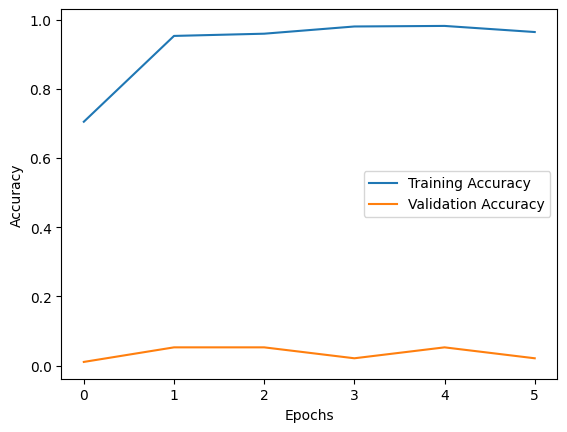

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
user_image_path = '/content/drive/MyDrive/CattleFace/test_image/5326-test3.jpg'
img = image.load_img(user_image_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

predictions = model.predict(img_array)

# Tahminlerden en yüksek olasılığa sahip sınıfın indexi
predicted_class_index = np.argmax(predictions[0])

# Eğitim veri kümesindeki sınıfların etiketlerini içeren sözlük
class_labels = train_generator.class_indices

# İndise karşılık gelen sınıf etiketi
predicted_class_label = [key for key, value in class_labels.items() if value == predicted_class_index][0]

print(f'Tahmin Edilen Sınıf Etiketi: {predicted_class_label}, Güven: {np.max(predictions)}')


1/1 [==============================] - 3s 3s/step
Tahmin Edilen Sınıf Etiketi: 5214, Güven: 1.0
